In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as sps
import scipy as sp
from scipy import special
import lmfit as lm
import pymc3 as pm
import theano.tensor as tt
from theano import shared

In [2]:
def two_rates(t,k1,k2):
    if k1==k2:
        return k1**2*np.exp(-k1*t)
    else:
        return k1*k2/(k1-k2)*(np.exp(-k2*t)-np.exp(-k1*t))
    
def three_rates(t,k1,k2,k3):
    return k1*k2*k3/(k1-k2)*((np.exp(-k1*t)-np.exp(-k3*t))/(k1-k3)-(np.exp(-k2*t)-np.exp(-k3*t))/(k2-k3))

def four_rates(t,k1,k2,k3,k4):
    result=np.exp(-k2*t)/(k2-k3)/(k2-k4)
    result+=np.exp(-k3*t)*(k2-k1)/(k3-k1)/(k3-k2)/(k3-k4)
    result+=np.exp(-k1*t)/(k1-k3)/(k4-k1)
    result+=np.exp(-k4*t)*(k2-k1)/(k4-k1)/(k4-k2)/(k4-k3)
    return result*k1*k2*k3*k4/(k1-k2)

In [3]:
t_transfection = {
    "20171026_K1_gfp": 1.33,
    "20171026_K2_gfp": 1.33,
    "20171026_K3_gfp": 1.33,
    "20171026_K4_gfp": 1.33,
    "20171026_K5_gfp": 1.33,
    "20171026_K6_gfp": 1.33,
    "20170316_K1_gfp": 1,
    "20170316_K3_gfp": 1,
    "20170316_K5_gfp": 1,
    "20161006_DDC_gfp": -.3,
    "20161006_Lipo_gfp": -.3,
    "20161006_Lipo2_gfp": -.3,
}
analysis_excel = pd.read_excel("2017-11-20_onset/2017-11-20–113949_PARAMS_20171026_K2_gfp.xlsx",sheetname="par3")
analysis_excel

,t0,ktl,km,delta,beta,off
0,3.912078,9.643462e+03,0.019659,1.030140,2.405169e-04,31.100680
1,4.616926,5.102029e+03,0.022150,0.200414,1.257168e-01,39.804610
2,3.247641,2.121743e+03,0.010905,0.645181,1.636446e-05,42.497639
3,3.592629,8.030168e+03,0.009860,0.412235,1.607953e-04,52.783138
4,5.028051,6.697321e+03,0.007573,0.442341,1.851121e-04,51.211069
5,4.177280,6.084872e+03,0.013270,0.157625,8.724475e-02,49.857771
6,4.645768,3.210535e+03,0.009557,0.565382,1.381240e-05,43.038757
7,3.450061,1.302882e+04,0.010616,0.450602,1.211545e-04,48.779480
8,3.581630,1.488607e+05,0.005679,3.480580,6.249405e-37,42.408479
9,4.326860,3.401790e+03,0.031644,0.727757,3.346586e-02,44.024800


In [4]:
class BayesianModel(object):
    samples = 10000

    def __init__(self, cache_model=True):
        self.cached_model = None
        self.cached_start = None
        self.cached_sampler = None
        self.shared_vars = {}

    def cache_model(self, **inputs):
        self.shared_vars = self._create_shared_vars(**inputs)
        self.cached_model = self.create_model(**self.shared_vars)

    def create_model(self, **inputs):
        raise NotImplementedError('This method has to be overwritten.')

    def _create_shared_vars(self, **inputs):
        shared_vars = {}
        for name, data in inputs.items():
            shared_vars[name] = shared(np.asarray(data), name=name)
        return shared_vars

    def run(self, reinit=True, **inputs):
        if self.cached_model is None:
            self.cache_model(**inputs)

        for name, data in inputs.items():
            self.shared_vars[name].set_value(data)

        trace = self._inference(reinit=reinit)
        return trace

    def _inference(self, reinit=True):
        with self.cached_model:
            if reinit or (self.cached_start is None) or (self.cached_sampler is None):
                self.cached_start = pm.find_MAP()
                self.cached_sampler = pm.NUTS(scaling=self.cached_start)

            trace = pm.sample(self.samples, self.cached_sampler, start=self.cached_start)

        return trace

In [5]:
class Gamma_fixed_alpha(BayesianModel):
    """Bayesian model for a Ornstein-Uhlenback process.
    The model has inputs x, and prior parameters for
    gamma and inverse gamma distributions for D and A
    """

    def create_model(self, x=None, alpha=None, beta_min=None, beta_max=None):
        with pm.Model() as model:
            beta = pm.Uniform('beta',beta_min,beta_max)
            measurement = pm.Gamma('measurement',alpha=alpha,beta=beta,observed=x)
        return model

In [6]:
# calculate the posterior for different gamma distributions with natural number alpha's
data = np.array(analysis_excel['t0'])-1.33
print("t0 mean:",data.mean())
trace_list = []
gm = Gamma_fixed_alpha()
for n in range(1,15):
    trace = gm.run(x=data,
                    alpha=n,
                    beta_min=0,
                    beta_max=10)
    trace_list.append(trace)

t0 mean: 2.68977560915


logp = -3,980.4, ||grad|| = 2,091.4: 100%|██████████| 10/10 [00:00<00:00, 2051.71it/s]
100%|██████████| 10500/10500 [00:11<00:00, 905.48it/s]
logp = -3,137.6, ||grad|| = 1,923.4: 100%|██████████| 9/9 [00:00<00:00, 2040.36it/s]
100%|██████████| 10500/10500 [00:11<00:00, 938.74it/s] 
logp = -2,527.7, ||grad|| = 1,755.4: 100%|██████████| 9/9 [00:00<00:00, 1791.33it/s]
100%|██████████| 10500/10500 [00:10<00:00, 991.38it/s]
logp = -2,054, ||grad|| = 1,587.4: 100%|██████████| 8/8 [00:00<00:00, 1949.37it/s]
100%|██████████| 10500/10500 [00:11<00:00, 935.16it/s]
logp = -1,677, ||grad|| = 1,419.4: 100%|██████████| 8/8 [00:00<00:00, 1569.58it/s]
100%|██████████| 10500/10500 [00:11<00:00, 893.63it/s] 
logp = -1,375, ||grad|| = 1,251.4: 100%|██████████| 7/7 [00:00<00:00, 2074.63it/s]
100%|██████████| 10500/10500 [00:14<00:00, 704.43it/s]
logp = -1,134.3, ||grad|| = 1,083.4: 100%|██████████| 6/6 [00:00<00:00, 1783.17it/s]
100%|██████████| 10500/10500 [00:11<00:00, 906.81it/s] 
logp = -945.31, ||gra

In [7]:
beta_0_list=[]
beta_0_std_list=[]
for trace in trace_list:
    beta_0_list.append(trace['beta'].mean())
    beta_0_std_list.append(trace['beta'].std())
beta_0_list = np.array(beta_0_list)
beta_0_std_list = np.array(beta_0_std_list)


In [8]:
# now we need to calculate the likelihood function
def gamma_like(data,alpha,beta):
    p = sps.gamma.pdf(data,alpha,scale=1/beta)
    return np.prod(p)
def gamma_like_log(data,alpha,beta):
    p = np.log(sps.gamma.pdf(data,alpha,scale=1/beta))
    return np.sum(p)

In [9]:
p_like_list=[]
for n,beta_0 in enumerate(beta_0_list):
    p_like_list.append(gamma_like(data,n+1,beta_0))
p_like_list=np.array(p_like_list)

In [10]:
print(p_like_list*beta_0_std_list)

[  9.99543739e-293   2.02196522e-249   5.49133141e-231   3.82464393e-222
   1.94360571e-218   6.44552761e-218   1.45135109e-219   8.48632654e-223
   3.11711242e-227   1.31939344e-232   9.67775316e-239   1.64933507e-245
   8.65136879e-253   1.58737879e-260]


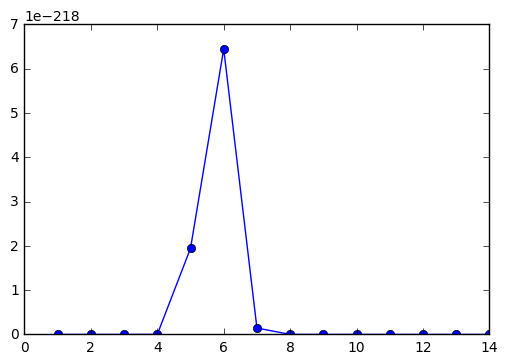

In [11]:
plt.plot(np.arange(14)+1,p_like_list*beta_0_std_list,"o-")

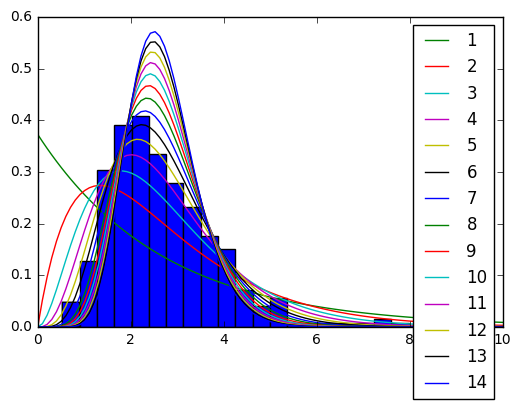

In [12]:
#plot the histogram and all the fits
x = np.linspace(0,10,100)
plt.hist(data, bins=20,normed=True)
for n,beta in enumerate(beta_0_list):
    plt.plot(x,sps.gamma.pdf(x,n+1,scale=1/beta),label=str(n+1))
    plt.legend()